In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import scipy.stats
import numpy as np
from statsmodels.stats.proportion import proportion_confint

In [2]:
df = pd.read_csv('data/bquxjob_29c884e7_1949d1db4fb.csv')

In [3]:
df.dtypes

c                             int64
cleaned_mno                  object
test_status                   int64
QOS_SignalStrength            int64
Connection_Category_clean    object
dtype: object

In [4]:
df.sample(5)

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
14192,28,raw_Tesco Mobile_Tesco,3,-98,4
2578,1,V,1,-61,5
6777,6,raw_giffgaff_O2,1,-86,4
12192,1,raw_giffgaff_O2 - UK,0,-78,4
12474,3,raw_giffgaff_giffgaff,3,-84,4


## Test status 0/1

In [5]:
def clean_test_status(status):
    return status.apply(lambda x: '1' if x==0 else 0)

In [6]:
df['test_status'] = clean_test_status(df['test_status'])

## Drop all but big 4 MNOs

In [7]:
df_big_four = df[df['cleaned_mno'].apply(lambda x:x in ['O2',3,'V','EE'])]

In [8]:
df_big_four.sample(5)

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
3874,6,EE,1,-45,4
3777,15,EE,0,-67,2
4267,16855,O2,1,-91,4
3809,7,EE,0,-86,4
3980,4,EE,0,-59,2


In [48]:
def get_baseline_success(df):
    print(df.groupby('test_status')['c'].sum())
    vals = df.groupby('test_status')['c'].sum().values
    rate = 100 * vals[1] / float(vals[0] + vals[1])
    print('Baseline success = {:.1f}%'.format(rate))
    return rate
# This is the baseline succes rate 

In [49]:
get_baseline_success(df)

test_status
0    1426129
1    4462880
Name: c, dtype: int64
Baseline success = 75.8%


75.78320902549139

In [50]:
get_baseline_success(df_big_four)

test_status
0     809589
1    2632192
Name: c, dtype: int64
Baseline success = 76.5%


76.47761435140701

In [51]:
df.sample(5)

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
7075,15,raw_plan.com_EE,1,-108,4
17607,1,raw_Honest Mobile_Three Mobile,0,-61,4
16781,24,raw_iD Mobile_Three Mobile,1,-87,4
4385,1354,O2,0,-95,4
12209,1,raw_giffgaff_O2 - UK,0,-105,2


In [52]:
df[df['QOS_SignalStrength'] == -17]['c'].sum()

18

## Drop category and MNO and aggregate

In [53]:
df.head()

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
0,1,raw_Yoigo_ehtelco,1,-108,4
1,6,raw_Tesco Mobile_O2,1,-107,4
2,1,raw_Superdrug Mobile_Three Mobile,1,-104,4
3,3,raw_3_Three,1,-103,3
4,2,raw_Lebara_vodafone UK,1,-114,4


In [214]:
g = df.groupby(['QOS_SignalStrength','test_status'])
# Drops technology and MNO

In [ ]:
if False:
    g = df.groupby(['QOS_SignalStrength','test_status','Connection_Category_clean'])
# Drops MNO only

## Sum over groups

In [215]:
aggregated = g.apply(lambda x: x['c'].sum())

In [216]:
aggregated[aggregated.index.get_level_values(0) == -17]

QOS_SignalStrength  test_status
-17                 0               3
                    1              15
dtype: int64

In [217]:
aggregated.sample(10)

QOS_SignalStrength  test_status
-96                 0              20975
-50                 1                205
-19                 1                 10
-86                 1              70201
-97                 0              29847
-82                 1              51029
-9                  1                  3
-45                 0                 23
-117                0              40026
-8                  0                  5
dtype: int64

In [218]:
n = aggregated.groupby(level=[0]).sum()

In [219]:
n.sample(5)

QOS_SignalStrength
-49       215
-6          6
-3         14
-56      1229
-94    133939
dtype: int64

## Normalise

In [220]:
normalised = aggregated/ n

In [221]:
normalised.sample(5)

QOS_SignalStrength  test_status
-98                 1              0.851014
-74                 1              0.885159
-129                0              0.818033
-84                 1              0.877547
-89                 1              0.837567
dtype: float64

In [222]:
len(pd.unique(normalised.index.get_level_values(0)))

126

In [223]:
normalised = normalised[normalised.index.get_level_values(1) == '1']
# Drop failure rate

In [224]:
len(pd.unique(normalised.index.get_level_values(0)))

120

In [225]:
normalised.sample(5)

QOS_SignalStrength  test_status
-109                1              0.695121
-1                  1              0.666667
-120                1              0.314600
-21                 1              0.842105
-15                 1              0.736842
dtype: float64

In [226]:
normalised = normalised.droplevel(1)

In [227]:
normalised.sample(5)

QOS_SignalStrength
-97    0.822586
-52    0.898795
-74    0.885159
-41    0.729730
-25    0.904762
dtype: float64

In [228]:
nDict = n.to_dict()

In [229]:
###normalised['n'] = map(lambda x:nDict[x],normalised.index.values)

In [230]:
normalised = pd.DataFrame(index = normalised.index, data = {'rate' : normalised.values\
                          ,'n':map(lambda x:nDict[x],normalised.index.values)})
# Turn MultiIndex series into dataframe

In [231]:
normalised.sample(5)

,rate,n
QOS_SignalStrength,,
-27,0.785714,14
-90,0.874347,106197
-101,0.802050,193554
-105,0.767232,217143
-102,0.819694,184808


## Add CIs

In [232]:
proportion_confint(1,100, method = 'binom_test',alpha = 0.95)

(0.009900989118484497, 0.019801982164531506)

In [233]:
def get_ci(row):
    return proportion_confint(int(row['rate'] * row['n']), row['n'], method = 'binom_test',alpha = 0.05)

In [234]:
normalised['intervals'] = normalised.apply(get_ci,axis = 1)

In [235]:
normalised.sample(5)

,rate,n,intervals
QOS_SignalStrength,,,
-59,0.781563,4198,"(0.7687187319300974, 0.7938504756821809)"
-11,0.800000,10,"(0.4464886649336679, 0.9632285621125349)"
-67,0.829218,14135,"(0.8229282655683186, 0.835344524682625)"
-124,0.212100,7025,"(0.20262080457584447, 0.22183906093462402)"
-99,0.811790,176696,"(0.8099594081924375, 0.813606920227629)"


In [236]:
def get_db_at_rate(df,rate = 0.5):
    return df[(df['rate'] > rate) & (df.index > -130)].sort_index().index[0]
# Add a hack to exclude very low signal with high rate but low n

## Plot (Full Dataset)

In [237]:
normalised['intervals'].sample(5)

QOS_SignalStrength
-5      (0.25708962392801743, 0.6882727073335969)
-90      (0.8723373166495104, 0.8763299022613684)
-98      (0.8493087810312989, 0.8527028737324199)
-138    (0.15096987834620137, 0.3347278728725266)
-113     (0.5734033782644196, 0.5783916042363523)
Name: intervals, dtype: object

In [294]:
def plot_rate(df, name = 'trash',add_rate = False):
    ax = plt.subplot()
    
    x_lims = [-140,-40]
    
    main_colour = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    
    df.plot(kind = 'line', ax = ax, y = 'rate', legend = False)
    # Plot rate
    
    plt.title('{:s} (n = {:.1f} k)'.format(name,df['n'].sum()/1000.))
    # Label with total sample size
    
    ax.fill_between(df.index, df['intervals'].apply(lambda x:x[0]), df['intervals'].apply(lambda x:x[1]), alpha = 0.5)
    # Add CIs

    if add_rate:
        for rate in [0.5, 0.75, 0.85]:
            plt.plot([get_db_at_rate(df,rate), get_db_at_rate(df,rate)],[0,rate], color = 'grey', linestyle = '--')
            plt.plot([x_lims[0],get_db_at_rate(df,rate)], [rate,rate], color = 'grey', linestyle = '--')
        
            plt.annotate('{:d}% : {:d} dB'.format(int(rate * 100), get_db_at_rate(df,rate)),xy = (-139, rate + 0.015),xycoords = 'data', color = 'grey')
        # Add annotations and lines at certain rates
    
    plt.xlim(x_lims)
    plt.ylim([0.0,1.0])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Drop frame
    
    plt.ylabel('Connectivity Success Rate')
    plt.xlabel('Signal Strength (dB)')
    # Label
    
    plt.savefig('figs/{:s}.png'.format(name),dpi = 300)
    plt.savefig('figs/{:s}.svg'.format(name))
    # Save

    plt.show()

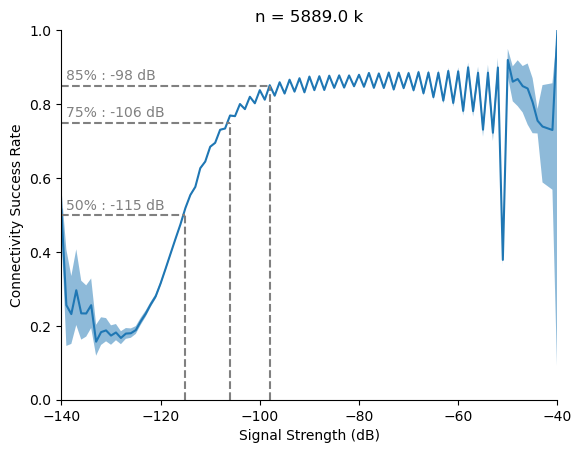

In [239]:
plot_rate(normalised,name = 'trash')

## Plot by MNO

In [317]:
def clean_non_big_four(mno):

    if mno in ['O2',3,'V','EE']:
        return mno
    else:
        return 'other'

In [318]:
df['cleaned_mno'] = df['cleaned_mno'].apply(clean_non_big_four)

In [319]:
g = df.groupby(['QOS_SignalStrength','test_status','cleaned_mno'])

In [320]:
aggregated = g.apply(lambda x: x['c'].sum())

In [321]:
n = aggregated.groupby(level=[0,2]).sum()
# Sum over groups of (signal,mno)

nDict = n.to_dict()

In [322]:
normalised = aggregated / n

In [323]:
normalised = normalised[normalised.index.get_level_values(2) == '1']
normalised = normalised.droplevel(2)
# Drop failure rate

In [324]:
def process_group(group,name = 'mno', add_rate = True):

    name = '{:s}_{:s}'.format(name, group.index[0][1].lower())
    
    group = pd.DataFrame(index = group.index, data = {'rate' : group.values\
                          ,'n':map(lambda x:nDict[x],group.index.values)})
    group = group.droplevel(1)
    # Now we can drop the MNO index
    
    group['intervals'] = group.apply(get_ci,axis = 1)
    plot_rate(group, name = name, add_rate = add_rate)
    #return group

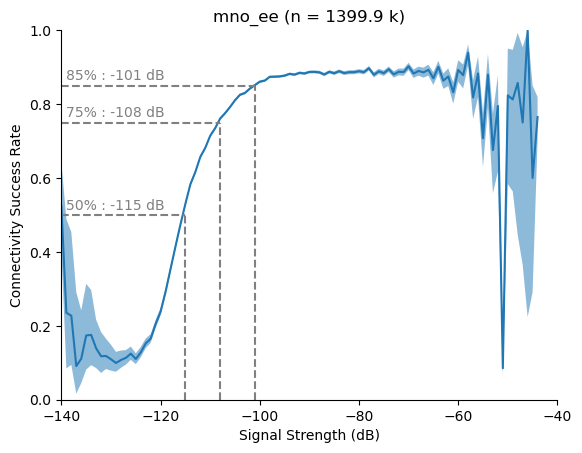

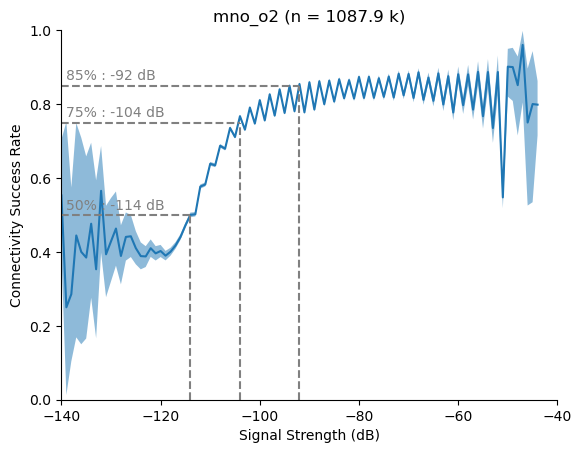

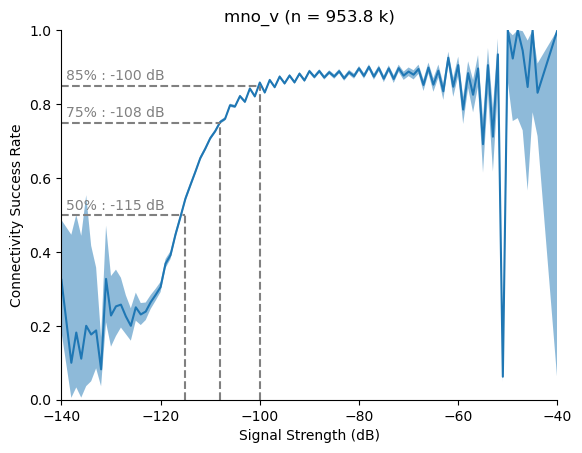

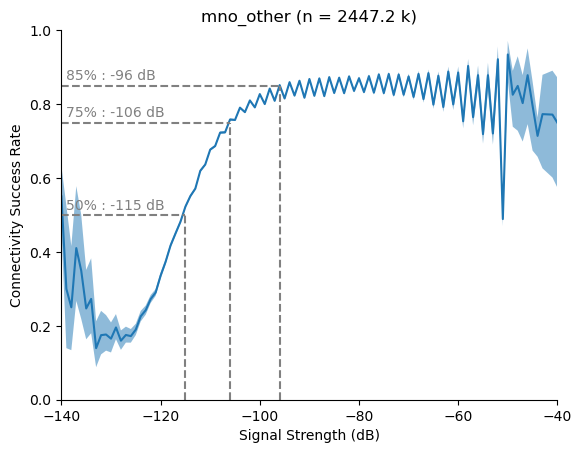

cleaned_mno
EE       None
O2       None
V        None
other    None
dtype: object

In [325]:
normalised.groupby('cleaned_mno').apply(lambda x: process_group(x,name = 'mno'))

## Plot by Technology

In [326]:
df.head()

,c,cleaned_mno,test_status,QOS_SignalStrength,Connection_Category_clean
0,1,other,1,-108,4
1,6,other,1,-107,4
2,1,other,1,-104,4
3,3,other,1,-103,3
4,2,other,1,-114,4


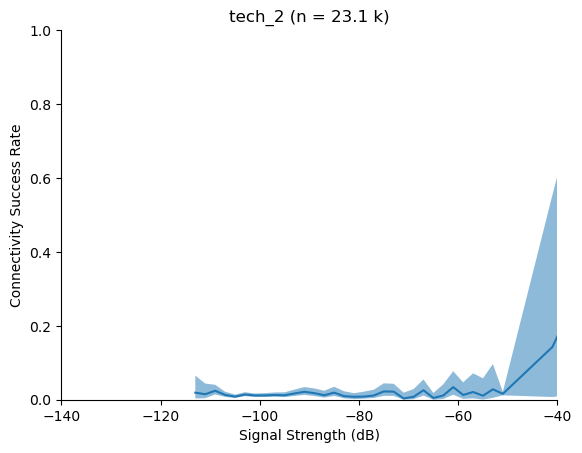

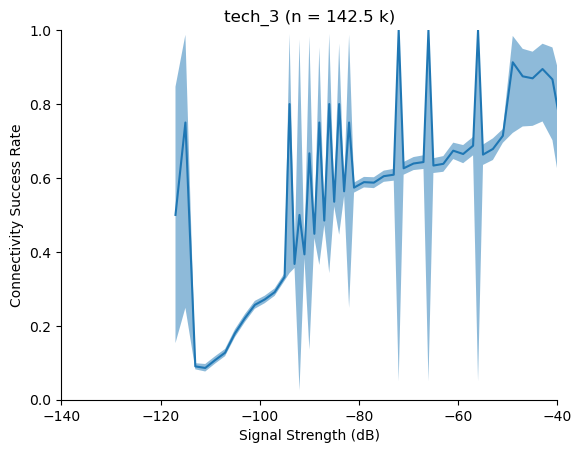

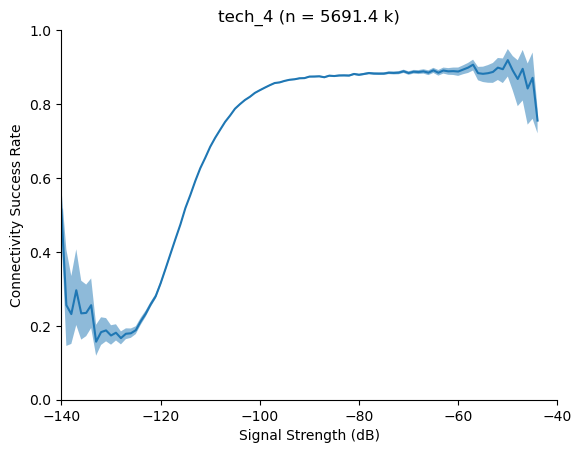

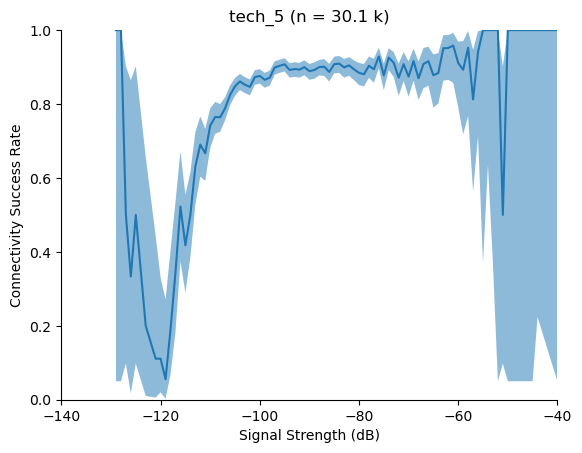

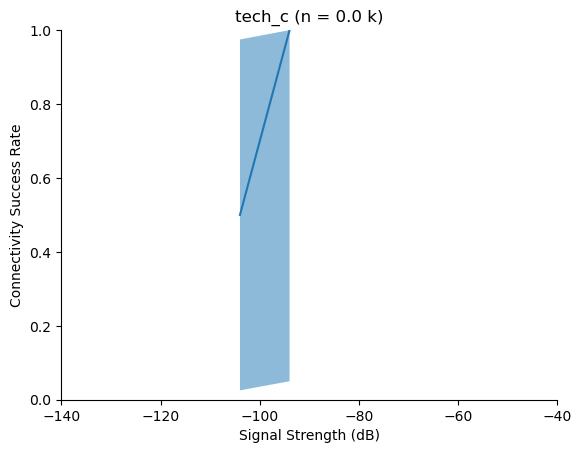

Connection_Category_clean
2    None
3    None
4    None
5    None
C    None
dtype: object

In [327]:
g = df.groupby(['QOS_SignalStrength','test_status','Connection_Category_clean'])
aggregated = g.apply(lambda x: x['c'].sum())
n = aggregated.groupby(level=[0,2]).sum()
# Sum over groups of (signal,tech)
nDict = n.to_dict()
normalised = aggregated / n
normalised = normalised[normalised.index.get_level_values(2) == '1']
normalised = normalised.droplevel(2)
# Drop failure rate
normalised.groupby('Connection_Category_clean').apply(lambda x: process_group(x,name = 'tech',add_rate=False))